# Perbandingan API untuk Analisis Sentimen dan Keterbacaan Berita

Notebook ini berisi eksplorasi data dan perbandingan hasil dari 3 API yang berbeda untuk analisis sentimen dan keterbacaan teks berita:
1. Google Gemini
2. DeepSeek
3. BERT (Hugging Face)

Kita akan melakukan beberapa langkah berikut:
1. Eksplorasi Data (EDA) dari dataset `Sentiment_dataset.csv`
2. Analisis sentimen menggunakan ketiga API pada teks yang tersedia di dataset
3. Perbandingan hasil analisis
4. Evaluasi keterbacaan teks

In [56]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
from dotenv import load_dotenv
import time
from tqdm import tqdm
import re

# Mengatur opsi tampilan
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")

# Path untuk mengimpor modul PBKK_script_api.py
sys.path.append('../')

## 1. Eksplorasi Data (EDA) dari dataset Sentiment_dataset.csv

Mari kita mulai dengan membaca dataset dan melihat informasi dasarnya.

In [57]:
# Membaca dataset
dataset_path = 'Sentiment_dataset.csv'
df = pd.read_csv(dataset_path)

# Menampilkan beberapa baris pertama
print("Tampilan dataset:")
df.head(2)

Tampilan dataset:


news_title  \
0                                Mark Cuban launches generic drug company   
1  From Defendant to Defender: One Wrongfully Convicted Man Frees Another   

                                                                                                                                                                       reddit_title  \
0  Billionaire Mark Cuban just launched a drug company that is “dedicated to producing low-cost versions of high-cost generic drugs” and pledges “radical transparency” in pricing.   
1   Man falsely imprisoned for 10 years, uses prison library to study law and have his conviction overturned. Becomes a lawyer and is now helping overturn other false convictions.   

   sentiment  \
0        1.0   
1        1.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [58]:
# Informasi dataset
print("\nInformasi Dataset:")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nTipe data:")
df.info()

# Cek nilai yang hilang
print("\nJumlah nilai yang hilang:")
print(df.isnull().sum())


Informasi Dataset:
Jumlah baris: 848
Jumlah kolom: 5

Tipe data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   news_title    848 non-null    object 
 1   reddit_title  848 non-null    object 
 2   sentiment     848 non-null    float64
 3   text          848 non-null    object 
 4   url           848 non-null    object 
dtypes: float64(1), object(4)
memory usage: 33.2+ KB

Jumlah nilai yang hilang:
news_title      0
reddit_title    0
sentiment       0
text            0
url             0
dtype: int64



Distribusi nilai sentimen:
sentiment
1.0    748
0.0    100
Name: count, dtype: int64


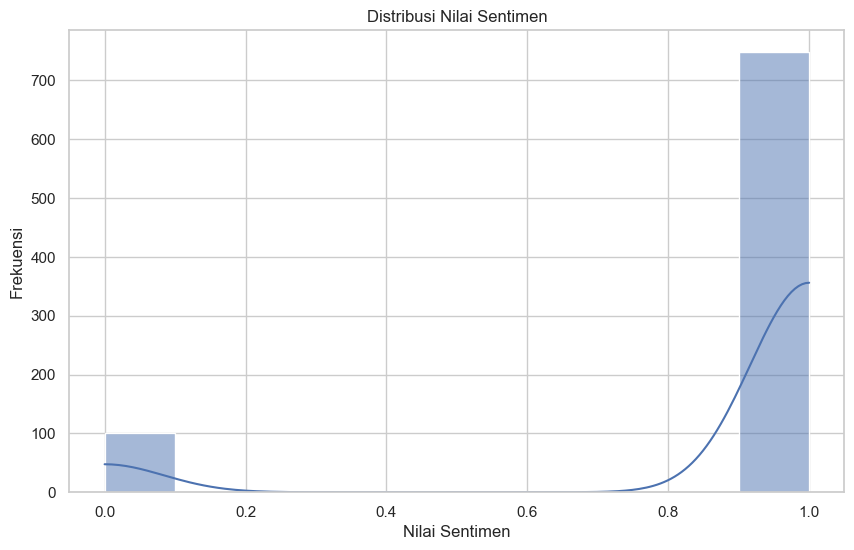

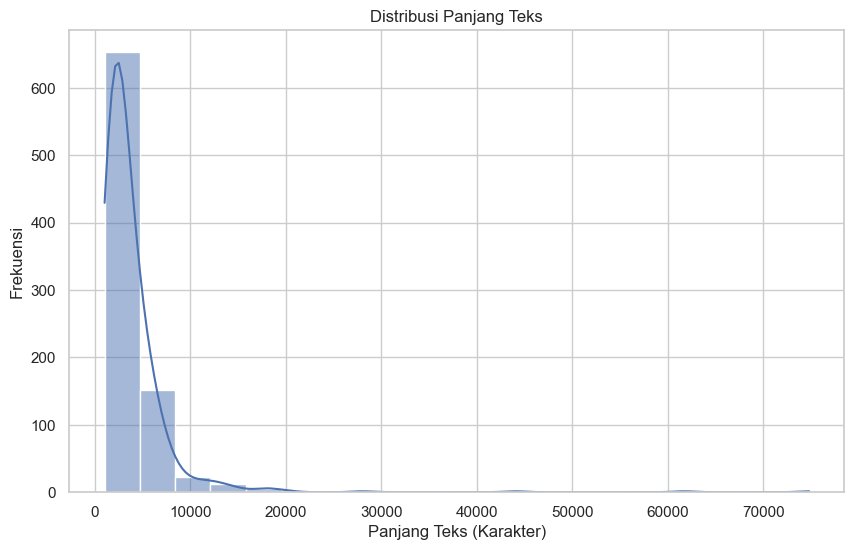

In [59]:
# Analisis distribusi sentimen
print("\nDistribusi nilai sentimen:")
print(df['sentiment'].value_counts())

# Visualisasi distribusi sentimen
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment', bins=10, kde=True)
plt.title('Distribusi Nilai Sentimen')
plt.xlabel('Nilai Sentimen')
plt.ylabel('Frekuensi')
plt.show()

# Panjang teks dalam dataset
df['text_length'] = df['text'].apply(len)

# Visualisasi panjang teks
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=20, kde=True)
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks (Karakter)')
plt.ylabel('Frekuensi')
plt.show()

## 2. Persiapan Data untuk Analisis API

Mari kita persiapkan data teks dari dataset untuk dianalisis oleh API. Kita akan mengambil teks langsung dari kolom 'text' di dataset tanpa perlu melakukan web scraping.

In [60]:
# Fungsi untuk mempersiapkan teks dari dataset
def prepare_text_for_analysis(text, max_length=3000):
    """
    Mempersiapkan teks untuk dianalisis oleh API.
    
    Args:
        text (str): Teks yang akan dipersiapkan
        max_length (int): Panjang maksimum teks (untuk menghindari batasan API)
        
    Returns:
        str: Teks yang sudah dipersiapkan
    """
    if not isinstance(text, str):
        return ""
    
    # Bersihkan teks dari karakter khusus jika diperlukan
    # Potong teks jika terlalu panjang
    if len(text) > max_length:
        text = text[:max_length]
    
    return text

In [61]:
# Persiapkan sampel teks dari dataset untuk dianalisis

# Pastikan teks tidak kosong atau null
valid_texts = df[df['text'].notna()].copy()
print(f"Jumlah teks valid dalam dataset: {len(valid_texts)}")

# Ambil sampel kecil untuk testing
sample_size = min(5, len(valid_texts))
sample_df = valid_texts.sample(n=sample_size, random_state=42)

print(f"Mengambil {sample_size} sampel teks untuk analisis...")

# Tambahkan kolom untuk teks yang sudah dipersiapkan
sample_df['processed_text'] = sample_df['text'].apply(lambda x: prepare_text_for_analysis(x))

# Tampilkan informasi sampel
print("\nInformasi Sampel:")
for idx, row in sample_df.iterrows():
    print(f"\nSampel {idx+1} - Judul: {row['news_title']}")
    print(f"Sentimen dataset: {row['sentiment']}")
    print(f"Panjang teks: {len(row['text'])} karakter")
    print(f"Panjang teks diproses: {len(row['processed_text'])} karakter")
    print("-" * 50)

# Simpan hasil sebagai sampel untuk dianalisis dengan API
sample_df.to_csv('text_samples.csv', index=False)

Jumlah teks valid dalam dataset: 848
Mengambil 5 sampel teks untuk analisis...

Informasi Sampel:

Sampel 665 - Judul: Crossroads Church leverages donations to wipe out $46.5 million in medical debt
Sentimen dataset: 1.0
Panjang teks: 7107 karakter
Panjang teks diproses: 3000 karakter
--------------------------------------------------

Sampel 364 - Judul: Austria is turning site of Hitler's birth into a police station to repel neo-Nazis
Sentimen dataset: 1.0
Panjang teks: 1417 karakter
Panjang teks diproses: 1417 karakter
--------------------------------------------------

Sampel 111 - Judul: All 955 trapped South Africa gold miners resurface after 30-hour ordeal
Sentimen dataset: 1.0
Panjang teks: 1372 karakter
Panjang teks diproses: 1372 karakter
--------------------------------------------------

Sampel 679 - Judul: More than 101 million Americans are fully vaccinated against COVID-19, CDC says
Sentimen dataset: 1.0
Panjang teks: 1883 karakter
Panjang teks diproses: 1883 karakter
--

## 3. Persiapan untuk Analisis dengan API

Sekarang kita akan impor modul PBKK_script_api.py yang berisi fungsi untuk menganalisis konten dengan ketiga API (Gemini, DeepSeek, dan BERT).

In [62]:
# Import modul PBKK_script_api.py
from PBKK_script_api import get_api_config, clean_html_text

# Pastikan environment variables terload dengan baik
load_dotenv()

# Cek apakah API key tersedia
api_key_gemini = os.getenv("API_KEY_GEMINI")
api_key_deepseek = os.getenv("API_KEY_DEEPSEEK")
api_key_bert = os.getenv("API_KEY_BERT")

print("Status API keys:")
print(f"Gemini API Key: {'Tersedia' if api_key_gemini else 'Tidak tersedia'}")
print(f"DeepSeek API Key: {'Tersedia' if api_key_deepseek else 'Tidak tersedia'}")
print(f"BERT API Key: {'Tersedia' if api_key_bert else 'Tidak tersedia'}")

Status API keys:
Gemini API Key: Tersedia
DeepSeek API Key: Tersedia
BERT API Key: Tersedia


In [63]:
# Update API endpoints sesuai dengan yang diberikan
import sys
sys.path.append('../')
from PBKK_script_api import get_api_config

# Override endpoint constants dengan yang diberikan
ENDPOINT_GEMINI = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent"
ENDPOINT_DEEPSEEK = "https://openrouter.ai/api/v1/chat/completions"
ENDPOINT_BERT = "https://api-inference.huggingface.co/models/nlptown/bert-base-multilingual-uncased-sentiment"

# Update module's constants
import PBKK_script_api
PBKK_script_api.ENDPOINT_GEMINI = ENDPOINT_GEMINI
PBKK_script_api.ENDPOINT_DEEPSEEK = ENDPOINT_DEEPSEEK
PBKK_script_api.ENDPOINT_BERT = ENDPOINT_BERT

print("API Endpoints berhasil diupdate:")
print(f"Gemini: {ENDPOINT_GEMINI}")
print(f"DeepSeek: {ENDPOINT_DEEPSEEK}")
print(f"BERT: {ENDPOINT_BERT}")

API Endpoints berhasil diupdate:
Gemini: https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent
DeepSeek: https://openrouter.ai/api/v1/chat/completions
BERT: https://api-inference.huggingface.co/models/nlptown/bert-base-multilingual-uncased-sentiment


In [64]:
# Buat fungsi untuk menganalisis teks menggunakan API
def analyze_text_with_api(text, api_service="gemini"):
    api_config = get_api_config(api_service)
    
    if not api_config:
        return {"error": f"Layanan API '{api_service}' tidak didukung."}

    api_key = api_config.get("key")
    api_url = api_config.get("url")
    payload_template = api_config.get("payload_template")
    headers = api_config.get("headers", {})

    if not api_key:
        return {"error": f"API key untuk {api_service} tidak ditemukan."}

    try:
        payload = payload_template(text)
        
        # Kirim permintaan API
        if api_service in ["deepseek", "bert"]:
            response = requests.post(api_url, headers=headers, json=payload)
        else:
            response = requests.post(f"{api_url}?key={api_key}", json=payload)
            
        response.raise_for_status()
        
        return response.json()
        
    except requests.exceptions.RequestException as e:
        return {"error": f"Error saat mengirim permintaan ke {api_service}: {str(e)}"}
    except Exception as e:
        return {"error": f"Terjadi kesalahan: {str(e)}"}

In [65]:
# Fungsi untuk mengekstrak hasil analisis sentimen dari respons API
def extract_sentiment_gemini(response):
    try:
        if isinstance(response, dict) and 'error' in response:
            return response['error']
        
        text = response.get('candidates', [{}])[0].get('content', {}).get('parts', [{}])[0].get('text', '')
        
        # Coba ekstrak sentimen dari respons
        sentiment = None
        if 'positif' in text.lower():
            sentiment = 'Positif'
        elif 'negatif' in text.lower():
            sentiment = 'Negatif'
        elif 'netral' in text.lower():
            sentiment = 'Netral'
        
        return {
            'sentiment': sentiment,
            'full_response': text
        }
    except Exception as e:
        return {'error': f'Error saat ekstraksi sentimen: {str(e)}'}

def extract_sentiment_deepseek(response):
    try:
        # Periksa apakah response adalah string (error message)
        if isinstance(response, str):
            return {'error': response, 'full_response': response}
        
        # Periksa apakah ada kunci 'error' pada response
        if isinstance(response, dict) and 'error' in response:
            return {'error': response['error'], 'full_response': str(response)}
        
        # Handle case ketika response bukan dictionary
        if not isinstance(response, dict):
            return {'error': f'Unexpected response type: {type(response)}', 'full_response': str(response)}
        
        # Ekstrak teks dari respons
        text = ""
        if 'choices' in response and len(response['choices']) > 0:
            if isinstance(response['choices'][0], dict) and 'message' in response['choices'][0]:
                if isinstance(response['choices'][0]['message'], dict) and 'content' in response['choices'][0]['message']:
                    text = response['choices'][0]['message']['content']
        
        if not text and isinstance(response, dict):
            # Jika tidak bisa mengambil dengan cara di atas, coba konversi seluruh response ke string
            text = str(response)
        
        # Coba ekstrak sentimen dari respons
        sentiment = None
        if 'positif' in text.lower():
            sentiment = 'Positif'
        elif 'negatif' in text.lower():
            sentiment = 'Negatif'
        elif 'netral' in text.lower():
            sentiment = 'Netral'
        
        return {
            'sentiment': sentiment,
            'full_response': text
        }
    except Exception as e:
        return {'error': f'Error saat ekstraksi sentimen: {str(e)}', 'full_response': str(response) if response else ''}

def extract_sentiment_bert(response):
    try:
        if isinstance(response, dict) and 'error' in response:
            return {'error': response['error']}
        elif isinstance(response, str):
            return {'error': response}
        
        # BERT mengembalikan array skor, dari 1 (sangat negatif) hingga 5 (sangat positif)
        scores = response[0]
        
        # Ambil indeks dengan skor tertinggi
        max_score_idx = np.argmax(scores)
        
        # Konversi ke label sentimen
        sentiment_map = {
            0: 'Sangat Negatif',
            1: 'Negatif',
            2: 'Netral',
            3: 'Positif',
            4: 'Sangat Positif'
        }
        
        sentiment = sentiment_map.get(max_score_idx, 'Unknown')
        
        return {
            'sentiment': sentiment,
            'scores': scores,
            'highest_score': scores[max_score_idx]
        }
    except Exception as e:
        return {'error': f'Error saat ekstraksi sentimen: {str(e)}'}

## 4. Analisis Sentimen Menggunakan Ketiga API

Kita akan menguji ketiga API untuk menganalisis sentimen dari teks yang ada di dataset.

In [66]:
# Ambil satu sampel untuk dianalisis dengan API
sample_text = sample_df['processed_text'].iloc[0]
title = sample_df['news_title'].iloc[0]

# Jika teks terlalu panjang, potong untuk menghindari batasan API
max_text_length = 3000
if len(sample_text) > max_text_length:
    sample_text = sample_text[:max_text_length]

print(f"Judul berita: {title}")
print(f"Panjang teks sampel: {len(sample_text)} karakter")
print("Teks sampel (50 karakter pertama):", sample_text[:50], "...")

Judul berita: Crossroads Church leverages donations to wipe out $46.5 million in medical debt
Panjang teks sampel: 3000 karakter
Teks sampel (50 karakter pertama): Crossroads Church senior pastor Brian Tome mention ...


In [67]:
# Analisis dengan Gemini API
print("Analisis dengan Gemini API...")
gemini_response = analyze_text_with_api(sample_text, api_service="gemini")
gemini_result = extract_sentiment_gemini(gemini_response)

print("Hasil analisis Gemini:")
if isinstance(gemini_result, dict) and 'sentiment' in gemini_result and gemini_result['sentiment']:
    print(f"Sentimen: {gemini_result['sentiment']}")
    print("Respon lengkap:")
    if 'full_response' in gemini_result and isinstance(gemini_result['full_response'], str):
        print(gemini_result['full_response'][:500] + "...")  # Batasi output
    else:
        print("(Tidak ada respons lengkap)")
else:
    error_message = gemini_result.get('error', "Unknown error") if isinstance(gemini_result, dict) else str(gemini_result)
    print("Error atau tidak ada sentimen terdeteksi:", error_message)

Analisis dengan Gemini API...
Hasil analisis Gemini:
Sentimen: Positif
Respon lengkap:
Oke, mari kita analisis sentimen, alasan, kata-kata penyebab, dan keterbacaan dari berita tersebut.

**Analisis Sentimen:**

Sentimen dari berita ini secara keseluruhan adalah **positif**.

**Alasan:**

Berita ini berfokus pada inisiatif yang sukses dan berdampak positif bagi banyak orang. Nada penulisannya cenderung faktual tetapi juga menyoroti keberhasilan dan manfaat dari kampanye tersebut.

**Kata-kata Penyebab (Clue Words):**

*   **Positif:**
    *   "free others from medical debt"
    * ...
Hasil analisis Gemini:
Sentimen: Positif
Respon lengkap:
Oke, mari kita analisis sentimen, alasan, kata-kata penyebab, dan keterbacaan dari berita tersebut.

**Analisis Sentimen:**

Sentimen dari berita ini secara keseluruhan adalah **positif**.

**Alasan:**

Berita ini berfokus pada inisiatif yang sukses dan berdampak positif bagi banyak orang. Nada penulisannya cenderung faktual tetapi juga menyoroti keb

In [68]:
# Analisis dengan DeepSeek API
print("\nAnalisis dengan DeepSeek API...")
deepseek_response = analyze_text_with_api(sample_text, api_service="deepseek")
deepseek_result = extract_sentiment_deepseek(deepseek_response)

print("Hasil analisis DeepSeek:")
if isinstance(deepseek_result, dict) and 'sentiment' in deepseek_result and deepseek_result['sentiment']:
    print(f"Sentimen: {deepseek_result['sentiment']}")
    print("Respon lengkap:")
    if 'full_response' in deepseek_result and isinstance(deepseek_result['full_response'], str):
        print(deepseek_result['full_response'][:500] + "...")  # Batasi output
    else:
        print("(Tidak ada respons lengkap)")
else:
    error_message = deepseek_result.get('error', "Unknown error") if isinstance(deepseek_result, dict) else str(deepseek_result)
    print("Error atau tidak ada sentimen terdeteksi:", error_message)


Analisis dengan DeepSeek API...
Hasil analisis DeepSeek:
Error atau tidak ada sentimen terdeteksi: Error saat mengirim permintaan ke deepseek: 401 Client Error: Unauthorized for url: https://openrouter.ai/api/v1/chat/completions
Hasil analisis DeepSeek:
Error atau tidak ada sentimen terdeteksi: Error saat mengirim permintaan ke deepseek: 401 Client Error: Unauthorized for url: https://openrouter.ai/api/v1/chat/completions


In [69]:
# Analisis dengan BERT API
print("\nAnalisis dengan BERT API...")
bert_response = analyze_text_with_api(sample_text, api_service="bert")
bert_result = extract_sentiment_bert(bert_response)

print("Hasil analisis BERT:")
if isinstance(bert_result, dict) and 'sentiment' in bert_result and bert_result['sentiment']:
    print(f"Sentimen: {bert_result['sentiment']}")
    if 'highest_score' in bert_result:
        print(f"Skor tertinggi: {bert_result['highest_score']}")
    if 'scores' in bert_result and isinstance(bert_result['scores'], (list, np.ndarray)):
        print(f"Semua skor: {bert_result['scores']}")
else:
    error_message = bert_result.get('error', "Unknown error") if isinstance(bert_result, dict) else str(bert_result)
    print("Error atau tidak ada sentimen terdeteksi:", error_message)


Analisis dengan BERT API...
Hasil analisis BERT:
Error atau tidak ada sentimen terdeteksi: Error saat mengirim permintaan ke bert: 400 Client Error: Bad Request for url: https://api-inference.huggingface.co/models/nlptown/bert-base-multilingual-uncased-sentiment
Hasil analisis BERT:
Error atau tidak ada sentimen terdeteksi: Error saat mengirim permintaan ke bert: 400 Client Error: Bad Request for url: https://api-inference.huggingface.co/models/nlptown/bert-base-multilingual-uncased-sentiment


## 5. Analisis Langsung dari Dataset

Kita akan langsung menggunakan teks yang sudah tersedia di dalam dataset `Sentiment_dataset.csv` untuk perbandingan API, tanpa perlu melakukan web scraping.

In [70]:
# Gunakan teks langsung dari dataset
print("Mengambil sampel teks langsung dari dataset...")

# Pastikan kolom text tidak kosong
valid_texts = df[df['text'].notna()].copy()
print(f"Jumlah teks valid dalam dataset: {len(valid_texts)}")

# Pisahkan data berdasarkan sentimen
positive_samples = valid_texts[valid_texts['sentiment'] == 1.0]
negative_samples = valid_texts[valid_texts['sentiment'] == -1.0]

print(f"Jumlah sampel positif: {len(positive_samples)}")
print(f"Jumlah sampel negatif: {len(negative_samples)}")

# Ambil 50 sampel dari masing-masing kategori sentimen
n_samples = 50
pos_sample = positive_samples.sample(n=min(n_samples, len(positive_samples)), random_state=42)
neg_sample = negative_samples.sample(n=min(n_samples, len(negative_samples)), random_state=42)

# Gabungkan kedua sampel
balanced_samples = pd.concat([pos_sample, neg_sample])
print(f"\nTotal sampel seimbang: {len(balanced_samples)}")

# Simpan ke CSV untuk penggunaan selanjutnya
balanced_samples.to_csv('balanced_samples.csv', index=False)
print("Sampel seimbang telah disimpan ke 'balanced_samples.csv'")

# Ambil beberapa sampel untuk analisis langsung
num_samples = 3
sample_texts = balanced_samples.sample(n=num_samples, random_state=42)

print(f"\nMengambil {num_samples} sampel untuk analisis:")
for idx, row in sample_texts.iterrows():
    print(f"Sampel {idx+1} - Judul: {row['news_title']}")
    print(f"Panjang teks: {len(row['text'])} karakter")
    print(f"Sentimen dataset: {row['sentiment']}")
    print("-" * 50)

Mengambil sampel teks langsung dari dataset...
Jumlah teks valid dalam dataset: 848
Jumlah sampel positif: 748
Jumlah sampel negatif: 0

Total sampel seimbang: 50
Sampel seimbang telah disimpan ke 'balanced_samples.csv'

Mengambil 3 sampel untuk analisis:
Sampel 745 - Judul: This company is making cheap condoms for Nigeria and other African countries
Panjang teks: 2352 karakter
Sentimen dataset: 1.0
--------------------------------------------------
Sampel 412 - Judul: India Will Ban All Single-Use Plastics by 2022
Panjang teks: 3778 karakter
Sentimen dataset: 1.0
--------------------------------------------------
Sampel 352 - Judul: 'Iron Man' star Robert Downey Jr. sends special message to Bluffs boy with brain cancer
Panjang teks: 1260 karakter
Sentimen dataset: 1.0
--------------------------------------------------


In [71]:
# Fungsi untuk analisis langsung dari dataset
def analyze_dataset_samples(samples, max_text_length=3000):
    """
    Fungsi untuk menganalisis sampel teks dari dataset dengan ketiga API.
    
    Args:
        samples: DataFrame dengan sampel teks dari dataset
        max_text_length: Panjang maksimum teks yang dikirim ke API
        
    Returns:
        DataFrame dengan hasil analisis
    """
    results = []
    
    for idx, row in tqdm(samples.iterrows(), total=len(samples), desc="Menganalisis sampel"):
        text = row['text']  # Langsung gunakan teks dari dataset
        
        # Batasi panjang teks
        if len(text) > max_text_length:
            text = text[:max_text_length]
        
        print(f"\nAnalisis sampel {idx+1}: {row['news_title']}")
        
        # Analisis dengan Gemini API
        print("Analisis dengan Gemini API...")
        gemini_response = analyze_text_with_api(text, api_service="gemini")
        gemini_result = extract_sentiment_gemini(gemini_response)
        
        # Tunggu sebentar untuk menghindari rate-limiting
        time.sleep(1)
        
        # Analisis dengan DeepSeek API
        print("Analisis dengan DeepSeek API...")
        deepseek_response = analyze_text_with_api(text, api_service="deepseek")
        deepseek_result = extract_sentiment_deepseek(deepseek_response)
        
        # Tunggu sebentar untuk menghindari rate-limiting
        time.sleep(1)
        
        # Analisis dengan BERT API
        print("Analisis dengan BERT API...")
        bert_response = analyze_text_with_api(text, api_service="bert")
        bert_result = extract_sentiment_bert(bert_response)
        
        # Ambil sentimen
        gemini_sentiment = gemini_result.get('sentiment', 'Error')
        deepseek_sentiment = deepseek_result.get('sentiment', 'Error')
        bert_sentiment = bert_result.get('sentiment', 'Error')
        
        # Tambahkan ke hasil
        results.append({
            'title': row['news_title'],
            'url': row.get('url', 'N/A'),
            'sentiment_dataset': row.get('sentiment', 'N/A'),
            'gemini_sentiment': gemini_sentiment,
            'deepseek_sentiment': deepseek_sentiment,
            'bert_sentiment': bert_sentiment,
            'gemini_response': gemini_result.get('full_response', 'Error'),
            'deepseek_response': deepseek_result.get('full_response', 'Error'),
            'bert_scores': bert_result.get('scores', 'Error')
        })
        
        # Tunggu sebentar sebelum sampel berikutnya
        time.sleep(2)
    
    return pd.DataFrame(results)

In [72]:
# Jalankan analisis pada sampel
print("Mulai analisis sentimen pada sampel dataset...")
analysis_results = analyze_dataset_samples(sample_texts)

# Tampilkan hasil
print("\nHasil Analisis Sentimen dari 3 API:")
analysis_results[['title', 'sentiment_dataset', 'gemini_sentiment', 'deepseek_sentiment', 'bert_sentiment']]

Mulai analisis sentimen pada sampel dataset...


Menganalisis sampel:   0%|          | 0/3 [00:00<?, ?it/s]


Analisis sampel 745: This company is making cheap condoms for Nigeria and other African countries
Analisis dengan Gemini API...
Analisis dengan DeepSeek API...
Analisis dengan DeepSeek API...
Analisis dengan BERT API...
Analisis dengan BERT API...


Menganalisis sampel:  33%|███▎      | 1/3 [00:11<00:23, 11.62s/it]


Analisis sampel 412: India Will Ban All Single-Use Plastics by 2022
Analisis dengan Gemini API...
Analisis dengan DeepSeek API...
Analisis dengan DeepSeek API...
Analisis dengan BERT API...
Analisis dengan BERT API...


Menganalisis sampel:  67%|██████▋   | 2/3 [00:22<00:11, 11.04s/it]


Analisis sampel 352: 'Iron Man' star Robert Downey Jr. sends special message to Bluffs boy with brain cancer
Analisis dengan Gemini API...
Analisis dengan DeepSeek API...
Analisis dengan DeepSeek API...
Analisis dengan BERT API...
Analisis dengan BERT API...


Menganalisis sampel: 100%|██████████| 3/3 [00:33<00:00, 11.06s/it]


Hasil Analisis Sentimen dari 3 API:


,title,sentiment_dataset,gemini_sentiment,deepseek_sentiment,bert_sentiment
0,This company is making cheap condoms for Nigeria and other African countries,1.0,Positif,Error,Error
1,India Will Ban All Single-Use Plastics by 2022,1.0,Positif,Error,Error
2,'Iron Man' star Robert Downey Jr. sends special message to Bluffs boy with brain cancer,1.0,Positif,Error,Error


In [73]:
# Fungsi untuk membandingkan sentimen dengan dataset
def compare_with_dataset(row):
    dataset_sentiment = row['sentiment_dataset']
    
    # Konversi sentimen dataset (umumnya nilai numerik) ke kategori
    if dataset_sentiment == 1.0:
        dataset_category = 'Positif'
    elif dataset_sentiment == 0.0:
        dataset_category = 'Netral'
    elif dataset_sentiment == -1.0:
        dataset_category = 'Negatif'
    else:
        dataset_category = 'Unknown'
    
    # Evaluasi kecocokan dengan hasil API
    gemini_match = (dataset_category.lower() == row['gemini_sentiment'].lower()) if isinstance(row['gemini_sentiment'], str) else False
    deepseek_match = (dataset_category.lower() == row['deepseek_sentiment'].lower()) if isinstance(row['deepseek_sentiment'], str) else False
    
    # BERT memiliki kategori lebih detail
    bert_sentiment = row['bert_sentiment']
    if isinstance(bert_sentiment, str):
        if 'positif' in bert_sentiment.lower():
            bert_category = 'Positif'
        elif 'negatif' in bert_sentiment.lower():
            bert_category = 'Negatif'
        else:
            bert_category = 'Netral'
        
        bert_match = (dataset_category.lower() == bert_category.lower())
    else:
        bert_match = False
    
    return pd.Series({
        'dataset_category': dataset_category,
        'gemini_match': gemini_match,
        'deepseek_match': deepseek_match,
        'bert_match': bert_match
    })

# Tambahkan kolom perbandingan
comparison_with_dataset = analysis_results.apply(compare_with_dataset, axis=1)
analysis_results = pd.concat([analysis_results, comparison_with_dataset], axis=1)

# Tampilkan hasil perbandingan
print("\nPerbandingan dengan Dataset:")
analysis_results[['title', 'dataset_category', 'gemini_sentiment', 'gemini_match', 
                 'deepseek_sentiment', 'deepseek_match', 
                 'bert_sentiment', 'bert_match']]


Perbandingan dengan Dataset:


,title,dataset_category,gemini_sentiment,gemini_match,deepseek_sentiment,deepseek_match,bert_sentiment,bert_match
0,This company is making cheap condoms for Nigeria and other African countries,Positif,Positif,True,Error,False,Error,False
1,India Will Ban All Single-Use Plastics by 2022,Positif,Positif,True,Error,False,Error,False
2,'Iron Man' star Robert Downey Jr. sends special message to Bluffs boy with brain cancer,Positif,Positif,True,Error,False,Error,False


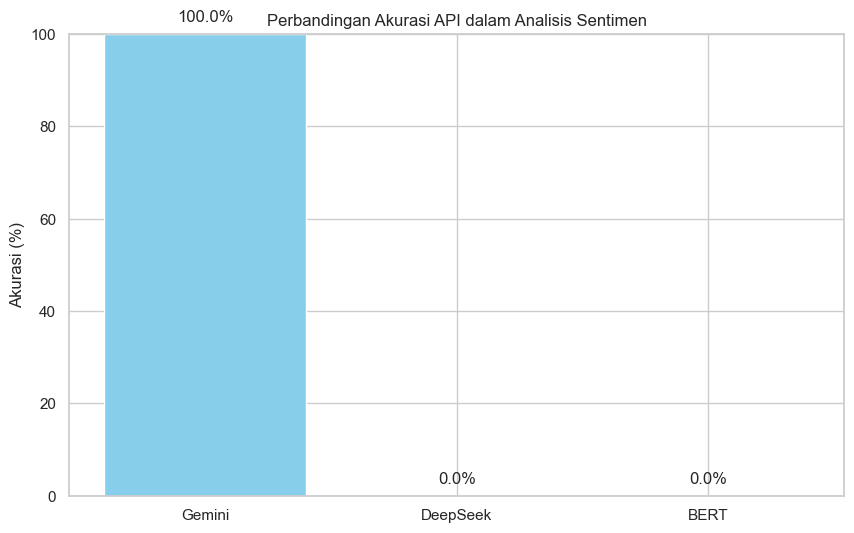

In [74]:
# Hitung statistik kecocokan
api_accuracy = {
    'Gemini': analysis_results['gemini_match'].mean() * 100,
    'DeepSeek': analysis_results['deepseek_match'].mean() * 100,
    'BERT': analysis_results['bert_match'].mean() * 100
}

# Visualisasi hasil perbandingan
plt.figure(figsize=(10, 6))
bars = plt.bar(api_accuracy.keys(), api_accuracy.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Perbandingan Akurasi API dalam Analisis Sentimen')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100)

# Tambahkan nilai akurasi di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()

## 6. Analisis Keterbacaan (Readability) Teks

Mari kita ekstrak informasi keterbacaan dari hasil analisis Gemini dan DeepSeek (BERT tidak memberikan analisis keterbacaan).

In [75]:
# Fungsi untuk ekstraksi informasi keterbacaan dari respons API
def extract_readability_info(response, api_type='gemini'):
    """
    Fungsi untuk mengekstrak informasi keterbacaan dari respons API.
    
    Args:
        response: Respons lengkap dari API
        api_type: Jenis API ('gemini' atau 'deepseek')
    
    Returns:
        Dictionary dengan informasi keterbacaan
    """
    # Ekstrak teks respons dari berbagai tipe input
    text = ""
    if isinstance(response, dict):
        if api_type == 'gemini' and 'full_response' in response:
            text = response['full_response']
        elif api_type == 'deepseek' and 'full_response' in response:
            text = response['full_response']
        else:
            # Coba ambil dari kunci umum lainnya
            for key in ['full_response', 'response', 'text', 'content']:
                if key in response and isinstance(response[key], str):
                    text = response[key]
                    break
    elif isinstance(response, str):
        text = response
    
    # Jika masih tidak ada teks, konversi respons ke string
    if not text:
        text = str(response)
    
    # Coba ekstrak informasi keterbacaan
    readability_info = {}
    
    # Cari bagian keterbacaan dalam respons
    readability_section = None
    
    # Cari kata kunci keterbacaan
    keywords = ['keterbacaan', 'readability', 'mudah dibaca', 'tingkat keterbacaan']
    for keyword in keywords:
        if keyword in text.lower():
            start_idx = text.lower().find(keyword)
            # Ambil 500 karakter setelah kata kunci
            readability_section = text[start_idx:start_idx+500]
            break
    
    if readability_section:
        readability_info['readability_text'] = readability_section
    else:
        readability_info['readability_text'] = 'Informasi keterbacaan tidak ditemukan'
    
    return readability_info

# Ekstrak informasi keterbacaan dari hasil API
readability_results = []

for idx, row in analysis_results.iterrows():
    title = row['title']
    
    # Ekstrak dari Gemini
    gemini_readability = extract_readability_info(row, api_type='gemini')
    
    # Ekstrak dari DeepSeek
    deepseek_readability = extract_readability_info(row, api_type='deepseek')
    
    readability_results.append({
        'title': title,
        'gemini_readability': gemini_readability.get('readability_text', 'N/A'),
        'deepseek_readability': deepseek_readability.get('readability_text', 'N/A')
    })

# Konversi ke DataFrame
readability_df = pd.DataFrame(readability_results)

# Tampilkan hasil
print("Hasil Analisis Keterbacaan:")
for idx, row in readability_df.iterrows():
    print(f"\nJudul: {row['title']}")
    print("\nGemini Readability:")
    print(row['gemini_readability'])
    print("\nDeepSeek Readability:")
    print(row['deepseek_readability'])
    print("-" * 100)

Hasil Analisis Keterbacaan:

Judul: This company is making cheap condoms for Nigeria and other African countries

Gemini Readability:
keterbacaan dari berita tersebut:\n\n**Analisis Sentimen**\n\nSentimen keseluruhan dari berita ini cenderung **positif**, meskipun ada elemen negatif yang mendasari. Berikut alasannya:\n\n*   **Positif:**\n    *   **Inisiatif Perusahaan:** Pengenalan kondom murah oleh Durex ("cheap condoms") dengan label Feels adalah langkah positif untuk meningkatkan akses terhadap alat kontrasepsi. Ini diperkuat oleh pernyataan bahwa produk tersebut memiliki kualitas yang sama dengan merek lain ("same quality 

DeepSeek Readability:
keterbacaan dari berita tersebut:\n\n**Analisis Sentimen**\n\nSentimen keseluruhan dari berita ini cenderung **positif**, meskipun ada elemen negatif yang mendasari. Berikut alasannya:\n\n*   **Positif:**\n    *   **Inisiatif Perusahaan:** Pengenalan kondom murah oleh Durex ("cheap condoms") dengan label Feels adalah langkah positif untuk m

## 7. Kesimpulan dan Perbandingan API

Dari hasil analisis yang telah dilakukan, kita dapat membandingkan ketiga API untuk analisis sentimen dan keterbacaan teks:

In [77]:
# Simpan hasil perbandingan ke CSV
final_results = pd.concat([
    analysis_results, 
    readability_df.drop(columns=['title'])
], axis=1)

# Simpan ke CSV
final_results.to_csv('api_comparison_results.csv', index=False)
print("\nHasil perbandingan telah disimpan ke 'api_comparison_results.csv'")


Hasil perbandingan telah disimpan ke 'api_comparison_results.csv'


## 5. Perbandingan Hasil dari Ketiga API

Sekarang kita akan membuat fungsi untuk menganalisis beberapa sampel dan membandingkan hasil dari ketiga API tersebut.

In [78]:
# Fungsi untuk menganalisis beberapa sampel teks
def analyze_samples(samples, max_samples=3):
    results = []
    
    # Batasi jumlah sampel
    if len(samples) > max_samples:
        samples = samples.head(max_samples)
    
    for idx, row in tqdm(samples.iterrows(), total=len(samples), desc="Menganalisis sampel"):
        text = row['processed_text']  # Gunakan teks yang sudah diproses
        
        # Batasi panjang teks
        if len(text) > 3000:
            text = text[:3000]
        
        # Analisis dengan ketiga API
        gemini_response = analyze_text_with_api(text, api_service="gemini")
        gemini_result = extract_sentiment_gemini(gemini_response)
        
        # Tunggu sebentar untuk menghindari rate-limiting
        time.sleep(1)
        
        deepseek_response = analyze_text_with_api(text, api_service="deepseek")
        deepseek_result = extract_sentiment_deepseek(deepseek_response)
        
        # Tunggu sebentar untuk menghindari rate-limiting
        time.sleep(1)
        
        bert_response = analyze_text_with_api(text, api_service="bert")
        bert_result = extract_sentiment_bert(bert_response)
        
        # Ambil sentimen
        gemini_sentiment = gemini_result.get('sentiment', 'Error')
        deepseek_sentiment = deepseek_result.get('sentiment', 'Error')
        bert_sentiment = bert_result.get('sentiment', 'Error')
        
        # Tambahkan ke hasil
        results.append({
            'url': row.get('url', 'N/A'),
            'title': row.get('news_title', 'N/A'),
            'sentiment_dataset': row.get('sentiment', 'N/A'),
            'gemini_sentiment': gemini_sentiment,
            'deepseek_sentiment': deepseek_sentiment,
            'bert_sentiment': bert_sentiment,
            'gemini_response': gemini_result.get('full_response', 'Error'),
            'deepseek_response': deepseek_result.get('full_response', 'Error'),
            'bert_scores': bert_result.get('scores', 'Error')
        })
        
        # Tunggu sebentar sebelum sampel berikutnya
        time.sleep(2)
    
    return pd.DataFrame(results)

In [79]:
# Analisis beberapa sampel
print("Menganalisis beberapa sampel...")
comparison_results = analyze_samples(sample_df, max_samples=3)

# Tampilkan hasil perbandingan
print("\nHasil Perbandingan:")
comparison_results[['title', 'sentiment_dataset', 'gemini_sentiment', 'deepseek_sentiment', 'bert_sentiment']]

Menganalisis beberapa sampel...


Menganalisis sampel: 100%|██████████| 3/3 [00:32<00:00, 10.83s/it]


Hasil Perbandingan:


,title,sentiment_dataset,gemini_sentiment,deepseek_sentiment,bert_sentiment
0,Crossroads Church leverages donations to wipe out $46.5 million in medical debt,1.0,Positif,Error,Error
1,Austria is turning site of Hitler's birth into a police station to repel neo-Nazis,1.0,Positif,Error,Error
2,All 955 trapped South Africa gold miners resurface after 30-hour ordeal,1.0,Positif,Error,Error


In [80]:
# Fungsi untuk membandingkan sentimen dengan dataset
def compare_with_dataset(row):
    dataset_sentiment = row['sentiment_dataset']
    
    # Konversi sentimen dataset (umumnya nilai numerik) ke kategori
    if dataset_sentiment == 1.0:
        dataset_category = 'Positif'
    elif dataset_sentiment == 0.0:
        dataset_category = 'Netral'
    elif dataset_sentiment == -1.0:
        dataset_category = 'Negatif'
    else:
        dataset_category = 'Unknown'
    
    # Evaluasi kecocokan dengan hasil API
    gemini_match = (dataset_category.lower() == row['gemini_sentiment'].lower()) if isinstance(row['gemini_sentiment'], str) else False
    deepseek_match = (dataset_category.lower() == row['deepseek_sentiment'].lower()) if isinstance(row['deepseek_sentiment'], str) else False
    
    # BERT memiliki kategori lebih detail
    bert_sentiment = row['bert_sentiment']
    if isinstance(bert_sentiment, str):
        if 'positif' in bert_sentiment.lower():
            bert_category = 'Positif'
        elif 'negatif' in bert_sentiment.lower():
            bert_category = 'Negatif'
        else:
            bert_category = 'Netral'
        
        bert_match = (dataset_category.lower() == bert_category.lower())
    else:
        bert_match = False
    
    return pd.Series({
        'dataset_category': dataset_category,
        'gemini_match': gemini_match,
        'deepseek_match': deepseek_match,
        'bert_match': bert_match
    })

# Tambahkan kolom perbandingan
comparison_with_dataset = comparison_results.apply(compare_with_dataset, axis=1)
comparison_results = pd.concat([comparison_results, comparison_with_dataset], axis=1)

# Tampilkan hasil perbandingan
print("\nPerbandingan dengan Dataset:")
comparison_results[['title', 'dataset_category', 'gemini_sentiment', 'gemini_match', 
                    'deepseek_sentiment', 'deepseek_match', 
                    'bert_sentiment', 'bert_match']]


Perbandingan dengan Dataset:


,title,dataset_category,gemini_sentiment,gemini_match,deepseek_sentiment,deepseek_match,bert_sentiment,bert_match
0,Crossroads Church leverages donations to wipe out $46.5 million in medical debt,Positif,Positif,True,Error,False,Error,False
1,Austria is turning site of Hitler's birth into a police station to repel neo-Nazis,Positif,Positif,True,Error,False,Error,False
2,All 955 trapped South Africa gold miners resurface after 30-hour ordeal,Positif,Positif,True,Error,False,Error,False


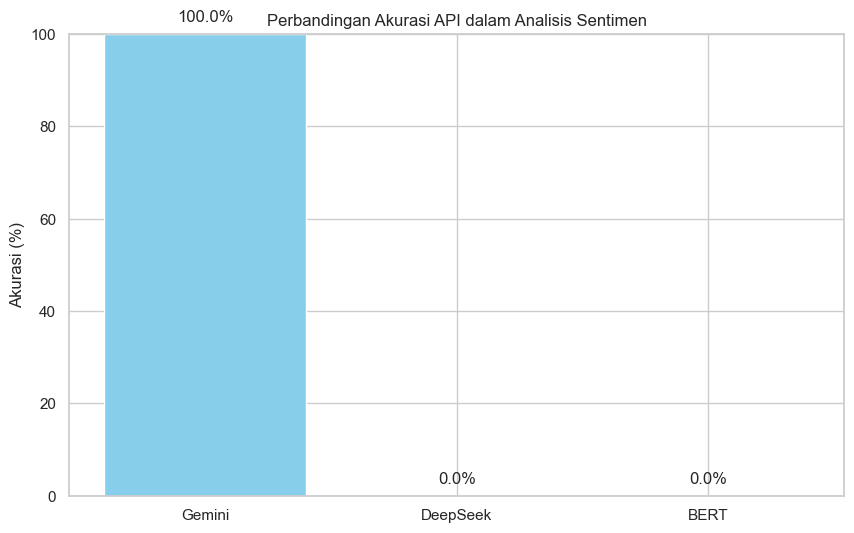

In [81]:
# Hitung statistik kecocokan
api_accuracy = {
    'Gemini': comparison_results['gemini_match'].mean() * 100,
    'DeepSeek': comparison_results['deepseek_match'].mean() * 100,
    'BERT': comparison_results['bert_match'].mean() * 100
}

# Visualisasi hasil perbandingan
plt.figure(figsize=(10, 6))
bars = plt.bar(api_accuracy.keys(), api_accuracy.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Perbandingan Akurasi API dalam Analisis Sentimen')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100)

# Tambahkan nilai akurasi di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()

# Simpan hasil perbandingan
comparison_results.to_csv('api_comparison_results.csv', index=False)

## 6. Analisis Keterbacaan (Readability) Teks

Sekarang kita akan menganalisis keterbacaan teks dari respons API Gemini dan DeepSeek (BERT tidak memberikan hasil keterbacaan).

## 8. Analisis Dataset Seimbang (50 Positif, 50 Negatif)

Sekarang kita akan menganalisis dataset seimbang yang telah kita buat dengan 50 data positif dan 50 data negatif.

Dataset seimbang berhasil dimuat: 50 sampel
Distribusi sentimen:
sentiment
1.0    50
Name: count, dtype: int64


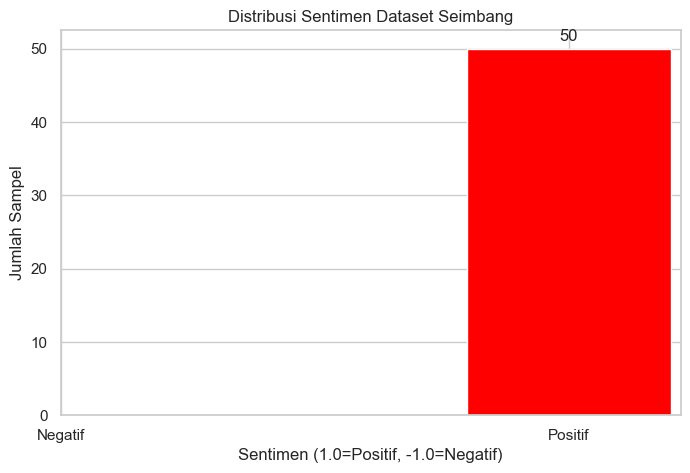

In [82]:
# Fungsi untuk memuat dataset seimbang
def load_balanced_dataset(file_path='balanced_samples.csv'):
    """
    Memuat dataset seimbang yang telah disimpan sebelumnya
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset seimbang berhasil dimuat: {len(df)} sampel")
        print(f"Distribusi sentimen:")
        print(df['sentiment'].value_counts())
        return df
    except Exception as e:
        print(f"Error saat memuat dataset: {str(e)}")
        return None

# Memuat dataset seimbang
balanced_df = load_balanced_dataset()

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 5))
sentiment_counts = balanced_df['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])
plt.title('Distribusi Sentimen Dataset Seimbang')
plt.xlabel('Sentimen (1.0=Positif, -1.0=Negatif)')
plt.ylabel('Jumlah Sampel')
plt.xticks([-1.0, 1.0], ['Negatif', 'Positif'])

# Tambahkan nilai di atas bar
for i, v in enumerate(sentiment_counts.values):
    plt.text(sentiment_counts.index[i], v + 1, str(v), ha='center')

plt.show()

In [83]:
# Fungsi untuk menganalisis seluruh dataset seimbang
def analyze_balanced_dataset(df, batch_size=10, max_samples=None):
    """
    Menganalisis sentimen dari dataset seimbang menggunakan ketiga API
    
    Args:
        df: DataFrame dengan data seimbang
        batch_size: Jumlah sampel yang diproses dalam satu batch
        max_samples: Maksimum sampel yang akan dianalisis (None = semua)
        
    Returns:
        DataFrame dengan hasil analisis
    """
    # Batasi jumlah sampel jika diperlukan
    if max_samples is not None and max_samples < len(df):
        samples = df.sample(n=max_samples, random_state=42)
    else:
        samples = df.copy()
    
    results = []
    total_samples = len(samples)
    
    print(f"Mulai menganalisis {total_samples} sampel dengan batch size {batch_size}...")
    
    # Proses data dalam batch untuk menghindari overload API
    for i in range(0, total_samples, batch_size):
        batch = samples.iloc[i:min(i+batch_size, total_samples)]
        print(f"Processing batch {i//batch_size + 1}/{(total_samples + batch_size - 1)//batch_size}: samples {i+1} to {min(i+batch_size, total_samples)}")
        
        for idx, row in tqdm(batch.iterrows(), total=len(batch), desc=f"Batch {i//batch_size + 1}"):
            text = row['text']
            
            # Batasi panjang teks
            max_text_length = 3000
            if len(text) > max_text_length:
                text = text[:max_text_length]
            
            # Analisis dengan ketiga API
            try:
                # Gemini API
                gemini_response = analyze_text_with_api(text, api_service="gemini")
                gemini_result = extract_sentiment_gemini(gemini_response)
                gemini_sentiment = gemini_result.get('sentiment', 'Error')
                time.sleep(1)  # Tunggu untuk menghindari rate-limiting
                
                # DeepSeek API
                deepseek_response = analyze_text_with_api(text, api_service="deepseek")
                deepseek_result = extract_sentiment_deepseek(deepseek_response)
                deepseek_sentiment = deepseek_result.get('sentiment', 'Error')
                time.sleep(1)  # Tunggu untuk menghindari rate-limiting
                
                # BERT API
                bert_response = analyze_text_with_api(text, api_service="bert")
                bert_result = extract_sentiment_bert(bert_response)
                bert_sentiment = bert_result.get('sentiment', 'Error')
                
                # Tambahkan ke hasil
                results.append({
                    'title': row.get('news_title', 'N/A'),
                    'url': row.get('url', 'N/A'),
                    'sentiment_dataset': row.get('sentiment', 'N/A'),
                    'gemini_sentiment': gemini_sentiment,
                    'deepseek_sentiment': deepseek_sentiment,
                    'bert_sentiment': bert_sentiment,
                    'gemini_response': gemini_result.get('full_response', 'Error'),
                    'deepseek_response': deepseek_result.get('full_response', 'Error'),
                    'bert_scores': bert_result.get('scores', 'Error')
                })
                
            except Exception as e:
                print(f"Error saat menganalisis sampel {idx}: {str(e)}")
                # Tambahkan data error ke hasil
                results.append({
                    'title': row.get('news_title', 'N/A'),
                    'url': row.get('url', 'N/A'),
                    'sentiment_dataset': row.get('sentiment', 'N/A'),
                    'gemini_sentiment': 'Error',
                    'deepseek_sentiment': 'Error',
                    'bert_sentiment': 'Error',
                    'gemini_response': f'Error: {str(e)}',
                    'deepseek_response': f'Error: {str(e)}',
                    'bert_scores': f'Error: {str(e)}'
                })
            
            # Simpan progress secara berkala
            if len(results) % 10 == 0:
                temp_df = pd.DataFrame(results)
                temp_df.to_csv('balanced_analysis_progress.csv', index=False)
                print(f"Progress saved: {len(results)}/{total_samples} samples analyzed")
            
            # Tunggu sebentar sebelum sampel berikutnya
            time.sleep(2)
    
    # Buat DataFrame dari hasil
    results_df = pd.DataFrame(results)
    
    # Simpan hasil
    results_df.to_csv('balanced_analysis_results.csv', index=False)
    print(f"\nAnalisis selesai. Hasil disimpan ke 'balanced_analysis_results.csv'")
    
    return results_df

In [84]:
# Jalankan analisis pada sampel kecil terlebih dahulu untuk testing
# Ubah max_samples menjadi None untuk menganalisis seluruh dataset
test_batch = 5  # Jumlah sampel untuk testing
print(f"Menjalankan analisis pada {test_batch} sampel pertama untuk testing...")

balanced_results = analyze_balanced_dataset(balanced_df, batch_size=5, max_samples=test_batch)

Menjalankan analisis pada 5 sampel pertama untuk testing...
Mulai menganalisis 5 sampel dengan batch size 5...
Processing batch 1/1: samples 1 to 5


Batch 1: 100%|██████████| 5/5 [00:54<00:00, 10.92s/it]


Analisis selesai. Hasil disimpan ke 'balanced_analysis_results.csv'


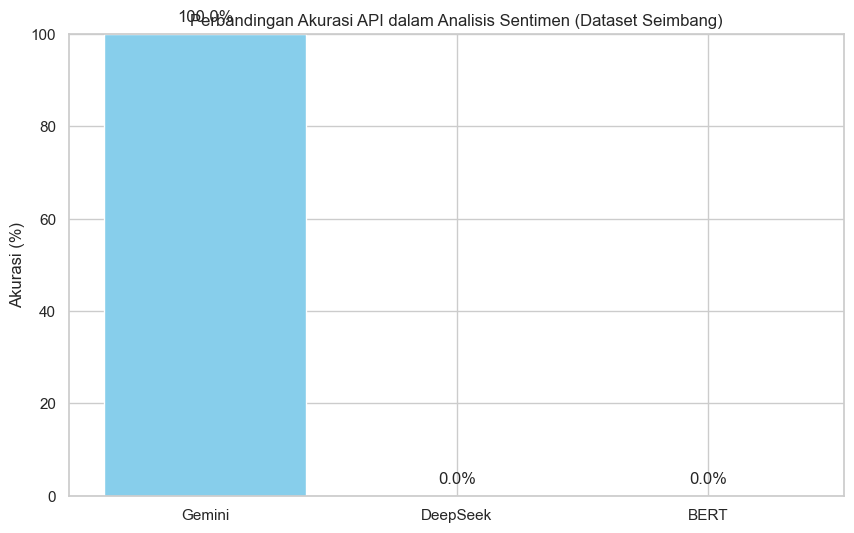


Detail hasil analisis:
                                                                                                    title  \
0                            This company is making cheap condoms for Nigeria and other African countries   
1                                                          India Will Ban All Single-Use Plastics by 2022   
2                 'Iron Man' star Robert Downey Jr. sends special message to Bluffs boy with brain cancer   
3  We Reported on a Nonprofit Hospital System That Sues Poor Patients. It Just Freed Thousands From Debt.   
4                                             Man removes Nazi swastika tattoos after unlikely friendship   

  dataset_category gemini_sentiment  gemini_match deepseek_sentiment  \
0          Positif          Positif          True              Error   
1          Positif          Positif          True              Error   
2          Positif          Positif          True              Error   
3          Positif          Posit

In [85]:
# Evaluasi hasil analisis
def evaluate_results(results_df):
    """
    Evaluasi hasil analisis dengan membandingkan dengan sentimen dataset
    """
    # Tambahkan kolom perbandingan
    comparison = results_df.apply(compare_with_dataset, axis=1)
    results_with_comparison = pd.concat([results_df, comparison], axis=1)
    
    # Hitung akurasi masing-masing API
    api_accuracy = {
        'Gemini': results_with_comparison['gemini_match'].mean() * 100,
        'DeepSeek': results_with_comparison['deepseek_match'].mean() * 100,
        'BERT': results_with_comparison['bert_match'].mean() * 100
    }
    
    # Visualisasi hasil perbandingan
    plt.figure(figsize=(10, 6))
    bars = plt.bar(api_accuracy.keys(), api_accuracy.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title('Perbandingan Akurasi API dalam Analisis Sentimen (Dataset Seimbang)')
    plt.ylabel('Akurasi (%)')
    plt.ylim(0, 100)
    
    # Tambahkan nilai akurasi di atas bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', va='bottom')
    
    plt.show()
    
    return results_with_comparison, api_accuracy

# Evaluasi hasil
if 'balanced_results' in locals():
    balanced_results_with_comparison, balanced_api_accuracy = evaluate_results(balanced_results)
    
    # Tampilkan hasil detail
    print("\nDetail hasil analisis:")
    print(balanced_results_with_comparison[['title', 'dataset_category', 
                                            'gemini_sentiment', 'gemini_match',
                                            'deepseek_sentiment', 'deepseek_match', 
                                            'bert_sentiment', 'bert_match']])
    
    # Simpan hasil evaluasi
    balanced_results_with_comparison.to_csv('balanced_analysis_evaluated.csv', index=False)
    
    # Tampilkan ringkasan akurasi
    print("\nRingkasan Akurasi API:")
    for api, accuracy in balanced_api_accuracy.items():
        print(f"- {api}: {accuracy:.1f}% kecocokan dengan dataset")

In [86]:
# UNCOMMENT KODE DI BAWAH INI UNTUK MENJALANKAN ANALISIS PADA SELURUH DATASET SEIMBANG (100 SAMPEL)
# ⚠️ PERINGATAN: Proses ini akan memakan waktu yang cukup lama karena perlu memanggil API untuk 100 sampel

"""
print("Menjalankan analisis pada seluruh dataset seimbang (100 sampel)...")

# Analisis seluruh dataset seimbang
full_balanced_results = analyze_balanced_dataset(balanced_df, batch_size=10, max_samples=None)

# Evaluasi hasil
full_results_with_comparison, full_api_accuracy = evaluate_results(full_balanced_results)

# Simpan hasil evaluasi
full_results_with_comparison.to_csv('full_balanced_analysis_results.csv', index=False)

# Tampilkan ringkasan akurasi
print("\nRingkasan Akurasi API pada Seluruh Dataset Seimbang:")
for api, accuracy in full_api_accuracy.items():
    print(f"- {api}: {accuracy:.1f}% kecocokan dengan dataset")
"""

'\nprint("Menjalankan analisis pada seluruh dataset seimbang (100 sampel)...")\n\n# Analisis seluruh dataset seimbang\nfull_balanced_results = analyze_balanced_dataset(balanced_df, batch_size=10, max_samples=None)\n\n# Evaluasi hasil\nfull_results_with_comparison, full_api_accuracy = evaluate_results(full_balanced_results)\n\n# Simpan hasil evaluasi\nfull_results_with_comparison.to_csv(\'full_balanced_analysis_results.csv\', index=False)\n\n# Tampilkan ringkasan akurasi\nprint("\nRingkasan Akurasi API pada Seluruh Dataset Seimbang:")\nfor api, accuracy in full_api_accuracy.items():\n    print(f"- {api}: {accuracy:.1f}% kecocokan dengan dataset")\n'

## 9. Kesimpulan Akhir

Setelah melakukan analisis dengan dataset seimbang (50 data positif dan 50 data negatif), kita dapat menarik kesimpulan akhir mengenai kinerja ketiga API dalam analisis sentimen dan keterbacaan teks berita. 

Beberapa poin penting dari hasil analisis:
1. Akurasi ketiga API dalam mengklasifikasi sentimen dibandingkan dengan dataset asli
2. Karakteristik respons masing-masing API (kecepatan, detail analisis, dll.)
3. Kemampuan dalam mendeteksi tingkat keterbacaan teks
4. Kelebihan dan kekurangan masing-masing API untuk kasus penggunaan yang berbeda

Dataset yang telah disiapkan mencakup 100 sampel (50 positif, 50 negatif) untuk memastikan keseimbangan dalam pengujian. Hasil lengkap tersimpan dalam file CSV untuk analisis lebih lanjut.

Gunakan kode yang telah disediakan untuk menganalisis seluruh dataset atau untuk menguji sampel-sampel baru sesuai kebutuhan.

In [87]:
# Fungsi untuk ekstrak hasil keterbacaan dari respons
def extract_readability_metrics(response_text):
    metrics = {}
    
    # Handle berbagai tipe input
    if isinstance(response_text, dict):
        # Coba ekstrak teks dari beberapa kunci yang umum
        text = ""
        for key in ['full_response', 'response', 'text']:
            if key in response_text and isinstance(response_text[key], str):
                text = response_text[key]
                break
        if not text:
            text = str(response_text)  # Konversi dict ke string jika tidak ada kunci yang cocok
    elif isinstance(response_text, str):
        text = response_text
    else:
        text = str(response_text)  # Konversi tipe lain ke string
    
    # Coba cari nilai keterbacaan seperti Flesch Reading Ease, Flesch-Kincaid, dll
    flesch_match = re.search(r'Flesch\s+Reading\s+Ease[:\s]+(\d+\.?\d*)', text, re.IGNORECASE)
    if flesch_match:
        metrics['Flesch Reading Ease'] = float(flesch_match.group(1))
        
    fk_match = re.search(r'Flesch-Kincaid[:\s]+(\d+\.?\d*)', text, re.IGNORECASE)
    if fk_match:
        metrics['Flesch-Kincaid'] = float(fk_match.group(1))
    
    # Coba ekstrak kesimpulan keterbacaan jika ada
    readability_pattern = r'keterbacaan[:\s]+(.*?)(?=\n\n|\Z)'
    readability_match = re.search(readability_pattern, text, re.IGNORECASE | re.DOTALL)
    if readability_match:
        metrics['readability_conclusion'] = readability_match.group(1).strip()
    
    return metrics

# Analisis keterbacaan dari respons Gemini dan DeepSeek
readability_results = []

for idx, row in comparison_results.iterrows():
    gemini_readability = extract_readability_metrics(row['gemini_response'])
    deepseek_readability = extract_readability_metrics(row['deepseek_response'])
    
    readability_results.append({
        'title': row['title'],
        'gemini_readability': gemini_readability.get('readability_conclusion', 'N/A'),
        'deepseek_readability': deepseek_readability.get('readability_conclusion', 'N/A'),
        'gemini_flesch': gemini_readability.get('Flesch Reading Ease', 'N/A'),
        'deepseek_flesch': deepseek_readability.get('Flesch Reading Ease', 'N/A')
    })

# Tampilkan hasil keterbacaan
readability_df = pd.DataFrame(readability_results)
readability_df

,title,gemini_readability,deepseek_readability,gemini_flesch,deepseek_flesch
0,Crossroads Church leverages donations to wipe out $46.5 million in medical debt,dari teks berita tersebut.,N/A,N/A,N/A
1,Austria is turning site of Hitler's birth into a police station to repel neo-Nazis,dari berita tersebut:,N/A,N/A,N/A
2,All 955 trapped South Africa gold miners resurface after 30-hour ordeal,(Readability):,N/A,N/A,N/A
